# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.0.2
- matplotlib 3.5.2

## Cargamos el dataset digits

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

## Lo escalamos

In [2]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(digits.data)

## Calculamos PCA a 64 componentes para obtener la curva de varianza

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
pca.fit(X)

PCA(n_components=64)

In [4]:
def plot_var_curve(X):
    plt.plot(X, lw=4)
    plt.grid(axis='y')
    plt.xlabel('Components')
    plt.ylabel('Variance')
    plt.title('Explained variance')
    

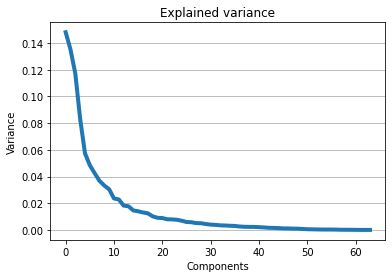

In [5]:
import matplotlib.pyplot as plt

plot_var_curve(pca.explained_variance_ratio_)

## Sobre la curva, acumulamos los valores para saber cuantas componentes necesitamos para retener un valor dado de varianza

In [6]:
def min_var(v,exp_var):
    acc = 0
    i=0
    while acc < v:
        acc += exp_var[i]
        i += 1
    return i


## Calculamos las componentes para retener el 90% de la varianza del dataset original
min_var(0.9,pca.explained_variance_ratio_)

22

## Calculamos PCA con 22 componentes

In [7]:
pca = PCA(n_components=22)
X_= pca.fit_transform(X)
print(X_.shape)

(1797, 22)


# Vecinos cercanos

## Vamos a probar los tres métodos para calcular vecinos cercanos

### Fuerza bruta (pairwise matrix)

In [8]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='brute', metric='euclidean').fit(X_)

In [9]:
distances, indices = nbrs.kneighbors(X_)

### n_neighbors = 2 significa el dato y su vecino más cercano

In [10]:
indices

array([[   0,  877],
       [   1,   93],
       [   2,   57],
       ...,
       [1794,  248],
       [1795,  254],
       [1796, 1705]])

In [11]:
distances

array([[0.00000000e+00, 5.27714973e-01],
       [0.00000000e+00, 7.82546086e-01],
       [0.00000000e+00, 9.69461456e-01],
       ...,
       [0.00000000e+00, 1.03808997e+00],
       [0.00000000e+00, 1.03447708e+00],
       [2.98023224e-08, 1.00575852e+00]])

Ver documentación de NearestNeighbors en: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors

## Ahora vamos a hacer lo mismo con un kd-tree

In [12]:
from sklearn.neighbors import KDTree

kdt = KDTree(X_, metric ='euclidean')
kdt.query(X_, k=2)

(array([[0.        , 0.52771497],
        [0.        , 0.78254609],
        [0.        , 0.96946146],
        ...,
        [0.        , 1.03808997],
        [0.        , 1.03447708],
        [0.        , 1.00575852]]),
 array([[   0,  877],
        [   1,   93],
        [   2,   57],
        ...,
        [1794,  248],
        [1795,  254],
        [1796, 1705]]))

## Y con un ball-tree

In [13]:
from sklearn.neighbors import BallTree

ball = BallTree(X_, metric='euclidean')
ball.query(X_, k=2)

(array([[0.        , 0.52771497],
        [0.        , 0.78254609],
        [0.        , 0.96946146],
        ...,
        [0.        , 1.03808997],
        [0.        , 1.03447708],
        [0.        , 1.00575852]]),
 array([[   0,  877],
        [   1,   93],
        [   2,   57],
        ...,
        [1794,  248],
        [1795,  254],
        [1796, 1705]]))

## Clasificador para predecir el dígito usando sus características PCA

### Datos anotados por humanos (ground truth)

In [14]:
y = digits.target

### Vamos a separar los datos en training/testing para que al entrenar el clasificador no usemos los datos con los que lo evaluaremos

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2)

### Ahora construimos el clasificador sobre la partición de training

In [16]:
from sklearn.neighbors import KNeighborsClassifier

nbrs = KNeighborsClassifier(n_neighbors=5)
clf = nbrs.fit(X_train, y_train)

### Y lo evaluamos sobre testing

In [17]:
clf.score(X_test, y_test)

0.975

In [18]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.97      0.97        40
           2       1.00      1.00      1.00        44
           3       0.97      1.00      0.98        29
           4       1.00      0.95      0.98        44
           5       0.94      1.00      0.97        33
           6       1.00      1.00      1.00        31
           7       0.97      0.97      0.97        39
           8       0.94      0.94      0.94        32
           9       0.94      0.91      0.92        32

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.98      0.97      0.97       360



## Finalmente vamos a detectar outliers usando LOF

In [19]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean')
lof.fit_predict(X_)
scores = lof.negative_outlier_factor_

## Los valores más pequeños (cercanos a 0) corresponden a inliers

In [20]:
scores

array([-1.00284273, -1.3695507 , -0.98056897, ..., -1.05935775,
       -1.10393173, -1.03943436])

### Vamos a plotear la distribución de LOFs

In [21]:
import numpy as np

def plot_hist(X, title):
    x, bins, patches = plt.hist(x=X, bins='auto', rwidth=0.85)
    plt.grid(axis='y')
    plt.xlabel('LOF')
    plt.ylabel('Frequency')
    plt.title(title)
    maxfreq = x.max()
    plt.ylim(ymax=np.ceil(maxfreq))


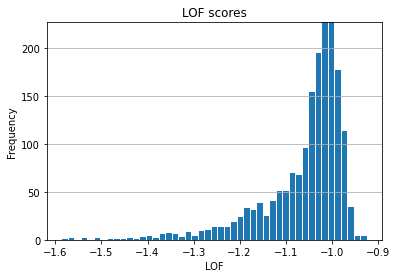

In [22]:
plot_hist(scores, 'LOF scores')

### Vamos a determinar el % de la muestra que está bajo un umbral de LOF

In [23]:
def lof_threshold(v,scores):
    N = len(scores)
    points = scores[scores < v]
    threshold = len(points)/N
    return threshold

In [24]:
lof_threshold(-1.4,scores)

0.009460211463550361

### Usamos el valor como parámetro para separar inliers y outliers (1 inliers, -1 outliers)

In [25]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean', contamination=0.009)
labels = lof.fit_predict(X_)